## Installations and imports

In [1]:
# Installations
!pip install lightgbm
!pip install matplotlib

In [2]:
# Imports
import numpy as np
import pandas as pd
import lightgbm as lgb
from collections import defaultdict

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

## Input loading and preprocessing



In [3]:
# Loading swipes data
swipes = pd.read_csv("swipes.csv")

In [4]:
# Checking the data
swipes.head()

,decidermemberid,othermemberid,timestamp,like,decidergender,othergender,deciderdobyear,otherdobyear,decidersignuptimestamp,othersignuptimestamp
0,3847776,3227524,2021-01-01 00:00:06,1,M,F,2002,1999,2020-12-28 11:19:02,2020-08-17 12:46:39
1,608590,519321,2021-01-01 00:00:06,0,F,M,1996,1992,2018-08-10 22:55:32,2018-06-17 15:34:37
2,397116,453914,2021-01-01 00:00:06,0,F,M,1991,1991,2018-03-04 22:14:06,2018-04-25 21:22:26
3,3847776,1269455,2021-01-01 00:00:06,1,M,F,2002,2000,2020-12-28 11:19:02,2019-04-22 20:02:54
4,1630969,347909,2021-01-01 00:00:23,0,F,M,1980,1983,2019-08-29 00:07:22,2018-01-17 12:14:03


In [5]:
# Checking how big is the data
swipes.shape

(9859578, 10)

In [6]:
# Checking missing data
swipes.isna().sum()

,0
decidermemberid,0
othermemberid,0
timestamp,0
like,0
decidergender,0
othergender,0
deciderdobyear,0
otherdobyear,0
decidersignuptimestamp,0
othersignuptimestamp,0


For this problem I selected only likes data because it provides a clear, unambiguous signal of positive user preference, making it ideal for training ranking models. Unlike swipes or profile views, which may reflect casual browsing or indecision, likes indicate genuine interest.

In [7]:
# Select only likes data
swipes = swipes[swipes['like'] == 1]

In [8]:
# Check data shape after the selection
swipes.shape

(3413063, 10)

In [9]:
# Converting decider member ids, other member ids to continuous ids
user_ids = swipes['decidermemberid'].unique()
item_ids = swipes['othermemberid'].unique()
user_to_idx = {u: i for i, u in enumerate(user_ids)}
item_to_idx = {i: j for j, i in enumerate(item_ids)}
swipes['user_idx'] = swipes['decidermemberid'].map(user_to_idx)
swipes['item_idx'] = swipes['othermemberid'].map(item_to_idx)

In [10]:
# Create core interation level features
swipes['age_diff'] = abs((2025 - swipes['deciderdobyear']) - (2025 - swipes['otherdobyear']))
swipes['hour'] = pd.to_datetime(swipes['timestamp']).dt.hour
swipes['night'] = ((swipes['hour'] >= 20) | (swipes['hour'] <= 1)).astype(int)
swipes['days_since'] = (pd.Timestamp.now() - pd.to_datetime(swipes['timestamp'])).dt.days

def hour_bucket(h):
    if 5 <= h < 12: return "morning"
    elif 12 <= h < 17: return "afternoon"
    elif 17 <= h < 21: return "evening"
    else: return "night"
swipes['hour_bucket'] = swipes['hour'].apply(hour_bucket)
swipes['age_group'] = pd.cut(swipes['age_diff'], bins=[-1,2,5,10,100], labels=['<=2','3-5','6-10','>10'])


## Data Splitting - Time based split

  - Time based splitting mimics the production where we predict future interactions.
  - Prevents data leakage from future to past

In [11]:
# Sorting the data according to timestamp
swipes.sort_values('timestamp', inplace=True)
split_idx = int(0.8 * len(swipes))
train_df = swipes.iloc[:split_idx].copy()
test_df = swipes.iloc[split_idx:].copy()

train_items_set = set(train_df['item_idx'])
test_df = test_df[test_df['item_idx'].isin(train_items_set)]  # keep unseen users, drop unseen items


## Feature Engineering
#### Aggregated user and iteam features
 - Summarizes historical behavior into meaningful numerical & categorical features.
 - Improves model's ability to generalize.


In [12]:
# User level aggregated features - train only to avoid leakage
user_features = train_df.groupby('user_idx').agg(
    user_activity=('user_idx', 'size'),
    user_night_ratio=('night', 'mean'),
    user_avg_age_diff=('age_diff', 'mean'),
    user_avg_recency=('days_since', 'mean'),
    top_hour_bucket=('hour_bucket', lambda x: x.mode().iloc[0] if not x.mode().empty else 'night'),
    deciderdobyear=('deciderdobyear', 'first')
).to_dict(orient='index')

In [13]:
# Item level aggregated features
item_features = train_df.groupby('item_idx').agg(
    item_avg_age_diff=('age_diff', 'mean'),
    item_avg_recency=('days_since', 'mean'),
    top_hour_bucket=('hour_bucket', lambda x: x.mode().iloc[0] if not x.mode().empty else 'night'),
    otherdobyear=('otherdobyear', 'first')
).to_dict(orient='index')

In [14]:
# Popularity and relationship features
item_pop = train_df['item_idx'].value_counts().to_dict()
mutual_likes = train_df.groupby(['item_idx', 'user_idx'])['like'].sum().to_dict()
user_agegroup_recency = train_df.groupby(['user_idx', 'age_group'])['days_since'].min().to_dict()


/tmp/ipython-input-2403599427.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_agegroup_recency = train_df.groupby(['user_idx', 'age_group'])['days_since'].min().to_dict()


In [15]:
# Negative sampling
def sample_hard_negatives(df_base, num_neg=5, sparse_user_thresh=10):
    """
    For sparse users:
        - Sample negatives with similar popularity & demographics (hard negatives).
    For active users:
        - Sample random negatives.
    """
    all_items = set(item_features.keys())
    item_pop_series = pd.Series(item_pop)
    item_age_series = pd.Series({i: itf.get('item_avg_age_diff', 0) for i, itf in item_features.items()})

    # Pre-bucket items for faster lookup
    pop_buckets, age_buckets = defaultdict(list), defaultdict(list)
    for i in all_items:
        pop_bucket = round(item_pop_series.get(i, 0) / max(1, item_pop_series.max()), 1)
        age_bucket = round(item_age_series.get(i, 0) / 2)
        pop_buckets[pop_bucket].append(i)
        age_buckets[age_bucket].append(i)

    user_pos_items = df_base.groupby('user_idx')['item_idx'].apply(set).to_dict()
    user_activity_count = df_base['user_idx'].value_counts().to_dict()

    negatives = []
    for u, pos_items in user_pos_items.items():
        use_hard = user_activity_count.get(u, 0) <= sparse_user_thresh
        possible_negs = list(all_items - pos_items)

        if use_hard:
            hard_candidates = set()
            for pos_item in pos_items:
                pop_bucket = round(item_pop_series.get(pos_item, 0) / max(1, item_pop_series.max()), 1)
                age_bucket = round(item_age_series.get(pos_item, 0) / 2)
                hard_candidates.update(pop_buckets.get(pop_bucket, []))
                hard_candidates.update(age_buckets.get(age_bucket, []))
            hard_candidates -= pos_items
            sampled = np.random.choice(list(hard_candidates) if hard_candidates else possible_negs,
                                       size=min(num_neg, len(hard_candidates) or len(possible_negs)),
                                       replace=False)
        else:
            sampled = np.random.choice(possible_negs, size=min(num_neg, len(possible_negs)), replace=False)

        negatives.extend((u, i, 0) for i in sampled)
    return negatives


In [16]:
# Combine positive and negative samples for training
neg_samples = sample_hard_negatives(train_df, num_neg=5)
pos_samples = [(row.user_idx, row.item_idx, 1) for row in train_df.itertuples(index=False)]
train_df_full = pd.DataFrame(pos_samples + neg_samples, columns=['user_idx', 'item_idx', 'label'])

In [18]:
def make_features(df_pairs):
    # Convert lookup dicts to DataFrames for fast merge
    uf_df = pd.DataFrame.from_dict(user_features, orient='index').reset_index().rename(columns={'index': 'user_idx'})
    itf_df = pd.DataFrame.from_dict(item_features, orient='index').reset_index().rename(columns={'index': 'item_idx'})

    # Merge user & item features
    feats = df_pairs.merge(uf_df, on='user_idx', how='left', suffixes=('', '_user'))
    feats = feats.merge(itf_df, on='item_idx', how='left', suffixes=('', '_item'))

    # Fill NaNs for missing users/items
    feats.fillna({
        'user_activity': 0,
        'user_night_ratio': 0,
        'user_avg_age_diff': 0,
        'user_avg_recency': 0,
        'top_hour_bucket': 'night',
        'deciderdobyear': 2000,
        'item_avg_age_diff': 0,
        'item_avg_recency': 0,
        'top_hour_bucket_item': 'night',
        'otherdobyear': 2000
    }, inplace=True)

    # Vectorized demographic similarity
    feats['age_diff'] = abs((2025 - feats['deciderdobyear']) - (2025 - feats['otherdobyear']))
    feats['age_group_match'] = (feats['age_diff'] <= 5).astype(int)

    # Mutual likes vectorized lookup
    mutual_likes_series = pd.Series(mutual_likes)
    mutual_likes_series.index = pd.MultiIndex.from_tuples(mutual_likes_series.index)
    feats['mutual_like_score'] = list(mutual_likes_series.reindex(list(zip(feats['item_idx'], feats['user_idx']))).fillna(0))

    # Vectorized age group + recency lookup
    feats['user_age_group'] = pd.cut(feats['age_diff'], bins=[-1,2,5,10,100], labels=['<=2','3-5','6-10','>10'])
    recency_lookup = pd.Series(user_agegroup_recency)
    recency_lookup.index = pd.MultiIndex.from_tuples(recency_lookup.index)
    feats['interaction_recency'] = list(recency_lookup.reindex(list(zip(feats['user_idx'], feats['user_age_group']))).fillna(999))

    # Hour bucket match
    feats['hour_bucket_match'] = (feats['top_hour_bucket'] == feats['top_hour_bucket_item']).astype(int)

    # Item popularity mapping
    feats['item_popularity'] = feats['item_idx'].map(item_pop).fillna(0)

    # Keep only required features
    return feats[[
        'user_activity',
        'user_night_ratio',
        'user_avg_age_diff',
        'user_avg_recency',
        'item_popularity',
        'item_avg_age_diff',
        'item_avg_recency',
        'age_diff',
        'age_group_match',
        'mutual_like_score',
        'interaction_recency',
        'hour_bucket_match',
        'label'
    ]]

In [19]:
# Create train features by calling the make_features
train_features = make_features(train_df_full)

# Features
features = [c for c in train_features.columns if c != 'label']

## Model training

In [53]:
# Model
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.04,
    num_leaves=50,
    random_state=42
)

# Fitting the model
lgb_model.fit(train_features[features], train_features['label'])

[LightGBM] [Info] Number of positive: 2730450, number of negative: 213415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1870
[LightGBM] [Info] Number of data points in the train set: 2943865, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.927505 -> initscore=2.548983
[LightGBM] [Info] Start training from score 2.548983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(learning_rate=0.04, n_estimators=300, num_leaves=50,
               random_state=42)

## Feature importance

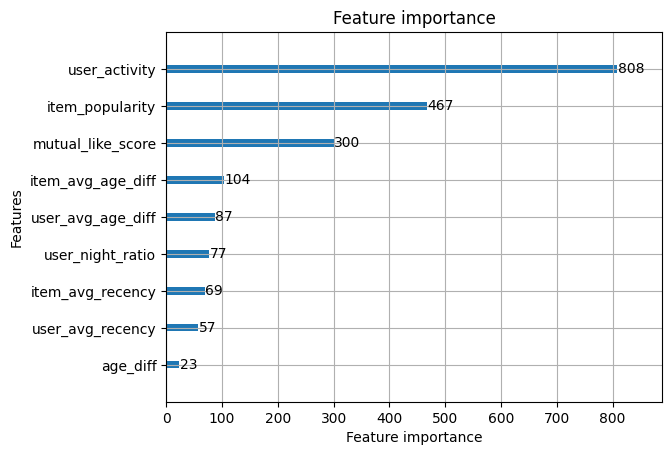

In [41]:
lgb.plot_importance(lgb_model, max_num_features=10)
plt.show()


The feature importance analysis shows that `user_activity` is the strongest predictor, followed by `item_popularity` and `mutual_like_score`, highlighting the dominance of behavioral engagement and popularity in driving recommendations. Demographic similarity features, such as `item_avg_age_diff` and `user_avg_age_diff`, play a moderate role, while temporal factors like `user_night_ratio` and `recency` metrics have lesser influence. Raw `age_diff` is the least important compare to `user_activity`. Overall, the model relies heavily on user engagement patterns and item popularity to make accurate recommendations.

## Evaluation

Hit Rate@K (also called Hit Ratio@K) is a metric that measures how often at least one of the true relevant items for a user appears in the top‑K recommendations. For example, HR@5 = 0.80 means that in 80% of cases, the model placed a correct item in the first 5 results. It aligns well with real‑world recommendation goals ensuring users quickly see something they like.

In [42]:
def hit_ratio_at_k_lgb(model, test_df, train_items_set, features_func, features, user_features, item_pop, K=5, allow_cold_start=False):
    """
    Fast HR@K computation by vectorizing candidate generation and feature computation.
    """
    all_rows = []
    for u in test_df['user_idx'].unique():
        test_items = list(test_df[test_df['user_idx'] == u]['item_idx'])
        if not test_items:
            continue

        possible_negs = list(train_items_set - set(test_items))
        sampled_negs = np.random.choice(possible_negs, size=50, replace=False) if possible_negs else []
        candidate_items = test_items + list(sampled_negs)

        if allow_cold_start and u not in user_features:
            # For cold-start: popularity ranking only
            sorted_items = sorted(candidate_items, key=lambda x: item_pop.get(x, 0), reverse=True)
            all_rows.extend([(u, i, 1 if i in test_items else 0, None) for i in sorted_items])
        else:
            # Collect (u, item, label) for later batch processing
            all_rows.extend([(u, i, 1 if i in test_items else 0, None) for i in candidate_items])

    candidates_df = pd.DataFrame(all_rows, columns=['user_idx', 'item_idx', 'label', 'score'])

    # Predict scores for all warm-start users in one go
    warm_mask = candidates_df['score'].isna()
    warm_df = candidates_df[warm_mask][['user_idx', 'item_idx', 'label']]

    if not warm_df.empty:
        feats = features_func(warm_df)
        scores = model.predict_proba(feats[features])[:, 1]
        candidates_df.loc[warm_mask, 'score'] = scores

    # For cold-start popularity scoring
    cold_mask = ~warm_mask
    candidates_df.loc[cold_mask, 'score'] = candidates_df.loc[cold_mask, 'item_idx'].map(item_pop)

    # Compute HR@K in vectorized form
    top_k_hits = (
        candidates_df.groupby('user_idx')
        .apply(lambda x: (x.sort_values('score', ascending=False).head(K)['label'] == 1).any())
        .mean()
    )

    return top_k_hits

In [54]:
# Calculating hit ratio for the test data
warm_hr5 = hit_ratio_at_k_lgb(lgb_model, test_df, train_items_set, make_features, features, user_features, item_pop, K=5, allow_cold_start=False)
cold_hr5 = hit_ratio_at_k_lgb(lgb_model, test_df, train_items_set, make_features, features, user_features, item_pop, K=5, allow_cold_start=True)

print("====================================")
print(f"Warm-start HR@5: {warm_hr5:.4f}")
print(f"Cold-start HR@5 (with fallback): {cold_hr5:.4f}")
print("====================================")

/tmp/ipython-input-560276521.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x.sort_values('score', ascending=False).head(K)['label'] == 1).any())


Warm-start HR@5: 0.7872
Cold-start HR@5 (with fallback): 0.7684


/tmp/ipython-input-560276521.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x.sort_values('score', ascending=False).head(K)['label'] == 1).any())


## Demonstration on few users

In [55]:
# Reverse mappings for display
idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_item = {v: k for k, v in item_to_idx.items()}

def recommend_with_cold_start(user_id, candidate_items, model, features_func, features, user_features, item_pop):
    """
    For warm-start users: rank using LightGBM model.
    For cold-start users: fall back to popularity-based ranking.
    """
    if user_id in user_features:
        df_candidates = pd.DataFrame({
            'user_idx': [user_id] * len(candidate_items),
            'item_idx': candidate_items,
            'label': [0] * len(candidate_items)  # dummy
        })
        feats = features_func(df_candidates)
        scores = model.predict_proba(feats[features])[:, 1]
        ranked_items = [candidate_items[i] for i in np.argsort(-scores)]
    else:
        ranked_items = sorted(candidate_items, key=lambda x: item_pop.get(x, 0), reverse=True)
    return ranked_items


In [56]:
# Selecting couple of users from the data
test_users = test_df['user_idx'].unique()
warm_test_users = [u for u in test_users if u in user_features][:2]
cold_test_users = [u for u in test_users if u not in user_features][:2]

def demo_recommendations(user_id):
    candidate_items = list(train_items_set)
    top_k = recommend_with_cold_start(
        user_id,
        candidate_items,
        lgb_model,
        make_features,
        features,
        user_features,
        item_pop
    )[:5]
    return top_k


In [57]:
print("=== Warm-start Users from Test Set ===")
for u in warm_test_users:
    orig_user_id = int(idx_to_user[u])
    past_items = train_df[train_df['user_idx'] == u].head(3)[['item_idx', 'like']].copy()
    past_items['othermemberid'] = past_items['item_idx'].map(lambda x: int(idx_to_item[x]))
    recs = demo_recommendations(u)
    recs_original_ids = [int(idx_to_item[i]) for i in recs]
    print(f"\nUser {u} (Original ID: {orig_user_id}):")
    print("  Past training interactions:\n", past_items[['othermemberid', 'like']].to_string(index=False))
    print("  Recommended items in Test:", recs_original_ids)

=== Warm-start Users from Test Set ===

User 5426 (Original ID: 1604738):
  Past training interactions:
  othermemberid  like
        268071     1
       1604511     1
       1768979     1
  Recommended items in Test: [3453579, 842856, 3093150, 2158225, 443973]

User 22062 (Original ID: 1029576):
  Past training interactions:
  othermemberid  like
       3124369     1
        797488     1
       3865364     1
  Recommended items in Test: [531135, 2535504, 3376923, 2529878, 2394369]


In [58]:
print("=== Cold-start Users from Test Set ===")
for u in cold_test_users:
    orig_user_id = idx_to_user.get(u, f"NEW_USER_{u}")
    if isinstance(orig_user_id, (np.integer, int)):
        orig_user_id = int(orig_user_id)
    recs = demo_recommendations(u)
    recs_original_ids = [int(idx_to_item[i]) for i in recs]
    print(f"\nNew User {u} (Original ID: {orig_user_id}):")
    print("  Recommended items (popularity-based):", recs_original_ids)

=== Cold-start Users from Test Set ===

New User 44663 (Original ID: 821715):
  Recommended items (popularity-based): [3844050, 3866079, 3865583, 3865854, 3868618]

New User 36960 (Original ID: 426836):
  Recommended items (popularity-based): [3844050, 3866079, 3865583, 3865854, 3868618]
